MTCNN算法简介
MTCNN（多任务级联卷积神经网络）由三个部分组成，P-Net（proposal Network），R-Net（refine Net），O-Net（outputNet）。

这三个部分是相互独立的三个网络结构，相互串联的关系。每个阶段的网络都是一个多任务网络，处理的任务有三个：人脸/非人脸的判断、人脸框回归、特征点定位。

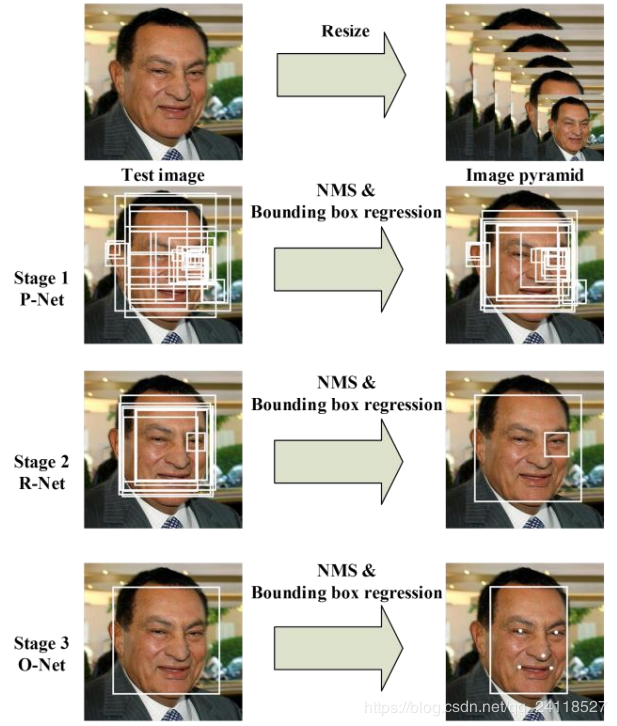
原始待检测图像经过resize，生成不同尺寸的图像构建图像金字塔作为网络的输入。

构建的图像金字塔，其层数由两个因素决定，第一个是设置的最小人脸minSize，第二个是缩放因子factor，最小人脸表示min(w,h)，论文中说明最小人脸不能小于12，给出的缩放因子0.709可以根据公式计算图像金字塔的层数

minL=org_L*(12/minsize)*factor^(n)，n={0,1,2,3,...,N}

其中n就是金字塔的层数，org_L是输入原始图像的最小边min(W,H),minisize是人为根据应用场景设定。在保证minL大于12的情况下，所有的n就构成金字塔的层。此时看上面那个公式，左边是常数，右边的minsize的值越小，n的取值范围就越大，计算量就相应地增加，能够检测到的人脸越小。

这一步如下图所示。

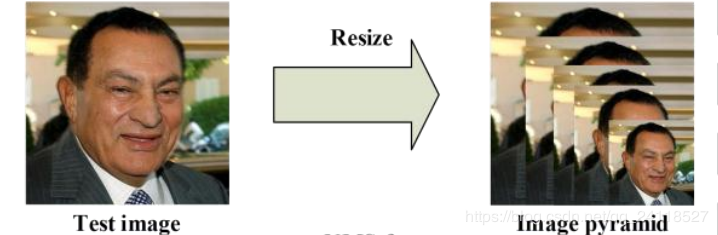

第一阶段，通过浅层的CNN（P-Net）快速生成候选窗口，该网络全部由卷积层实现，获取到候选人脸窗和人脸窗的回归向量，基于人脸窗的回归向量对人脸窗进行校正，然后对所有人脸窗进行NMS（非极大值抑制），合并高度重叠的人脸窗。其具体过程就是通过图像金字塔生成的各种尺寸大小的图片，每一张图都进行一次前向传播，在每个图上得到的结果之后利用设置的阈值去掉一部分，剩下的根据缩放尺度还原到原图上的坐标，将所有的坐标信息汇总，然后NMS去除一部分冗余。


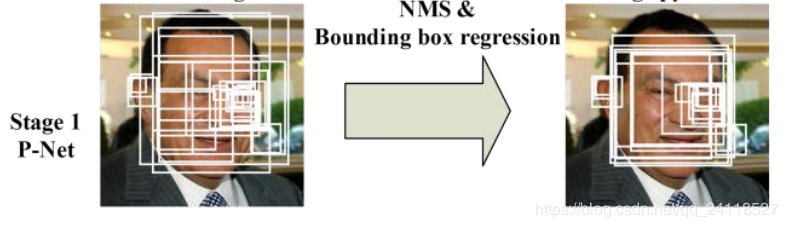

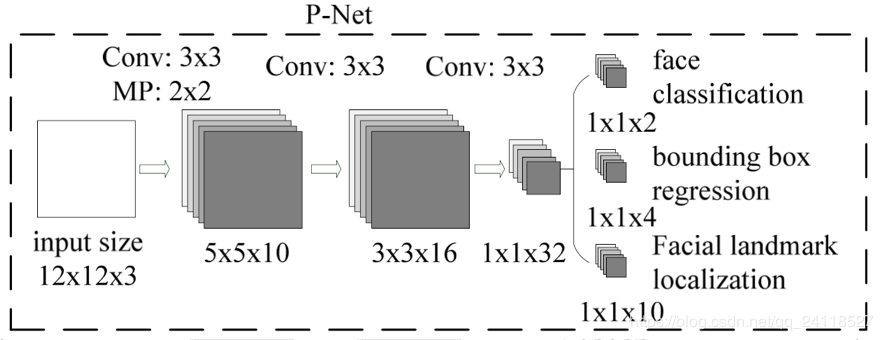
第二阶段，通过一个更复杂的CNN来处理第一阶段中被误认为人脸的“人脸窗”从而精细化人脸窗，第一阶段的输出作为第二阶段的输入，第一阶段最后产生了大量的bbox，将这些bbox根据缩放因子回推到原图上之后，将他们全部resize到24x24大小，作为第二阶段的输入。第二阶段经过网络之后同样产生大量的bbox，同样的根据阈值去掉一部分，再利用nms去掉一部分。

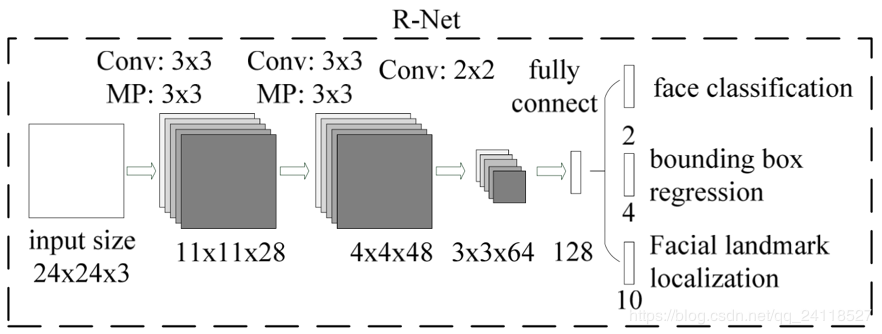

 第三阶段，使用第二阶段中最后留下来的bbox，还原到原来的图片上之后，全部resize到48x48大小，然后输入到第三阶段，使用更为复杂的CNN进一步精细化结果并输出人脸上的5个特征点。


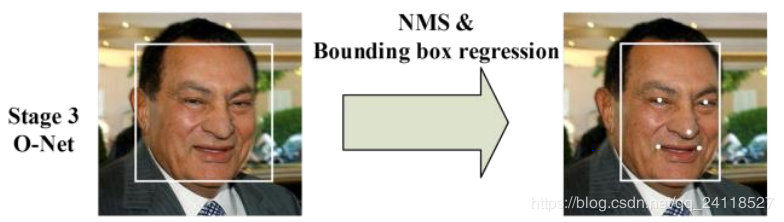
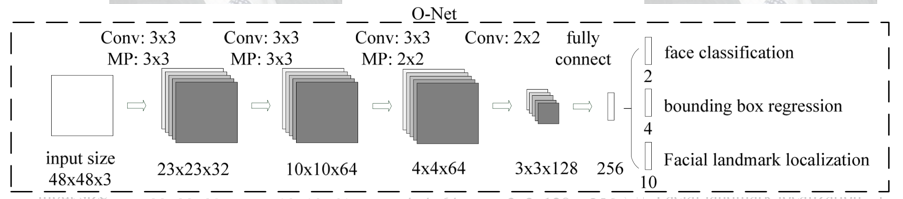

通过三阶的级联卷积神经网络对任务进行从粗到细的处理，并提出一种新的在线困难样本生成策略提升性能，最终输出人脸框位置和五个特征点位置。整个过程中会用到三次人脸窗回归和NMS，三个网络独立工作。

### 1. 加载库

In [1]:
# 关闭警告信息
import warnings
warnings.filterwarnings('ignore')

# Utilities库
import os
import sys
import random
from tqdm import tqdm
from scipy import misc

# 图像处理库
import cv2
import matplotlib.pyplot as plt

# tensorflow
import tensorflow as tf

# 识别函数
import detect_face

#### 设定参数

In [2]:
# 根目录
ROOT_DIR = os.getcwd()

# 验证用的资料目录
DATA_PATH = os.path.join(ROOT_DIR, "data")

# 验证图片路径
TEST_IMGS_PATH = os.path.join(DATA_PATH, "images")


In [3]:
minsize = 20 # 最小脸部大小
threshold = [ 0.6, 0.7, 0.7 ]  # 三个网络(P-Net, R-Net, O-Net)的阀值
factor = 0.709 # scale factor

gpu_memory_fraction=1.0

### 2. 建立MTCNN网络模型

In [4]:
print('Creating networks and loading parameters')

# 使用tensorflow执行
with tf.Graph().as_default():
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_memory_fraction)
        sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False))
        with sess.as_default():
            pnet, rnet, onet = detect_face.create_mtcnn(sess, None) # 構建三個網絡(P-Net, R-Net, O-Net)

Creating networks and loading parameters


### 3. 人脸检测

In [5]:
# 用來测试mtcnn的人臉检测图像
test_image= os.path.join(TEST_IMGS_PATH, "faces.jpg") 

# 使用OpenCV读取测试图

# 注意: OpenCV读取图片的Numpy Ndaary格式是BGR (B:Blue, G: Green, R: Red) 
#      跟使用PIL或skimage的格式RGB (R: Red, G: Green, B:Blue)在色阶(channel)的順序上有所不同
bgr_image = cv2.imread(test_image)
rgb_image = bgr_image[:,:,::-1] # 把BGR转换成RGB

# 检测人脸
bounding_boxes, _ = detect_face.detect_face(rgb_image, minsize, pnet, rnet, onet, threshold, factor)

Total faces detected ：40


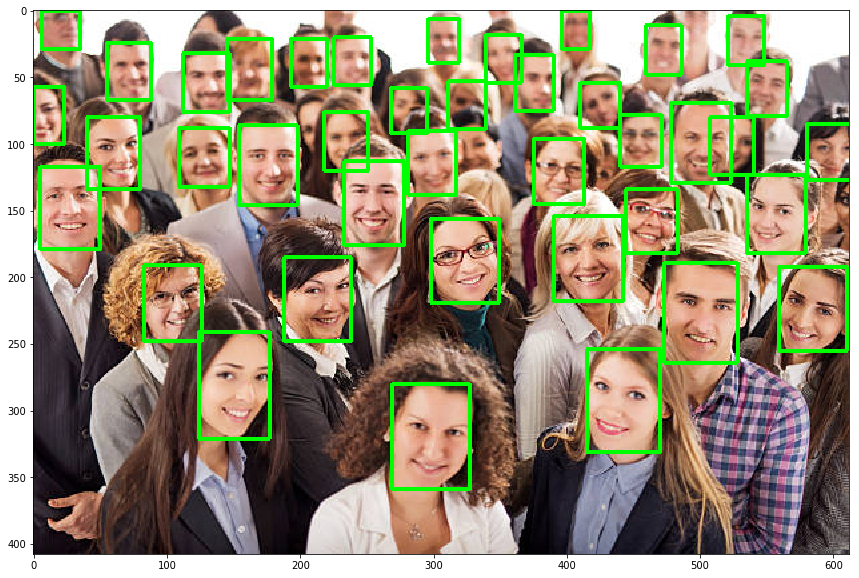

In [6]:
# 复制原图
draw = bgr_image.copy()

# 被检测的人脸总数
faces_detected = len(bounding_boxes)

print('Total faces detected ：{}'.format(faces_detected))

# 保留裁剪的人脸图
crop_faces=[]

# 每一个 bounding_box包括了（x1,y1,x2,y2,confidence score)：
# 　　左上角坐标 (x1,y1)
#     右下角坐标 (x2,y2)
#     信心分数 confidence score

# 迭代每一个检测出的边框
for face_position in bounding_boxes:
    # 把资料由float转成int
    face_position=face_position.astype(int)
    
    # 取出左上角坐标 (x1,y1)与右下角坐标 (x2,y2)
    # 由于有可能检测出來的脸在图像的图边而导致坐标值为负值
    # 进行的负值的检测于修正
    x1 = face_position[0] if face_position[0] > 0 else 0
    y1 = face_position[1] if face_position[1] > 0 else 0
    x2 = face_position[2] if face_position[2] > 0 else 0
    y2 = face_position[3] if face_position[3] > 0 else 0
    
    # 在原图像上画出边界框    
    cv2.rectangle(draw, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    # 进行脸部图像裁剪
    crop=bgr_image[y1:y2,x1:x2,]
    
    # 把脸部大小進行大小的修改后拋出給其它模组进行辨别(face recognition)
    # crop = cv2.resize(crop, (96, 96), interpolation=cv2.INTER_CUBIC )
    # crop_faces.append(crop)
    # plt.imshow(crop)
    # plt.show()

# 设定展示的大小
plt.figure(figsize=(20,10))

# 展示检测的结果
plt.imshow(draw[:,:,::-1]) # 转化成成RGB來給matplotlib展示
plt.show()